# Short term variations

## Introduction

I present here some preliminary results aimed at finding short time scale absorption line variations (~ minutes) likely caused by fast moving excomets close to the star (a few stellar radii). I have chosen to look at the far-UV SiIV doublet at 1394 and 1403 Å, because the exocometary variatons are evident, and the S/N is high for these lines, compared to other lines in the spectra. My hypothesis is that the emission originates from exocomets close to the star where the conditions for highly ionising Si are met.

## Aim
The aim is to look for short term variations. For this, I look at data taken during a single visit. In order to become sensitive to variations on the order of tens of minutes I have to divide the data into datasets of shorter exposuretimes. Fortunately this data is already available from the pipeline in fhe form of sumN.fits files, where N is an integer. I have been working with the \*sum[1..4].fits files where the average(*sum1.fits, *sum2.fits, *sum3.fits, *sum4.fits) = *sum.fits. This has the advantage that we have 4 times the number of spectra for a given visit at the cost of ~1/4 the exposure time.

### Please note

The notebook will not work until you have made edits the follwoing edits to the ```params.json``` file:

```"filesnames" : {
     "split_files" : "yes",
     "filename_start"  : "l",     
     "filename_end"  : "sum.fits" 
     },```

```"BetaPictoris" : {
     "RV": 20.5,    
     "part": "A"
     },```

```"datadirs" : {
     "2017_3": "data/2017-08-04/",
     "2017_4": "data/2017-10-21/" 
     },```

You have to run the **load_the_data** notebook once the parameters have been changed.

The split_files parameter needs to be set to "yes" and it is recommended you only select a few of the more recent datadirs. Finally, please run the notebook 'load_the_data' to create a new DP array which can then be loaded in this notebook.

The dates which support spilt files are:  
    "2017_1": "data/2017-04-23/",  
    "2017_2": "data/2017-06-10/",  
    "2017_3": "data/2017-08-04/",  
    "2017_4": "data/2017-10-21/",  
    "2017_5": "data/2017-11-26/",  
    "2018_1": "data/2018-03-17/",  
    "2018_2": "data/2018-05-09/",

### Load the data into a matrix of arrays

In [1]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

# get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions from src
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
c   = Calc()
m   = Model()
s   = Stats()

# Importing parameters from a json file.
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# We select part A which is the red end of the spectrum (the other part being B, which is the blue end)
part     = param["BetaPictoris"]["part"]

Repository home directory: /home/pas/science/exocomets


In [2]:
# The structure here is
# DP[visit][orbit][0 = wavelength, 1 = flux, 2 = one sigma uncertainty, 3 = datetime]
if param["filenames"]["split_files"] == "yes":
    DP   = c.LoadData(home+'/data/Dnsn_'+part+'_split.npz')
else:
    DP   = c.LoadData(home+'/data/Dnsn_'+part+'.npz')
    
ECF   = c.LoadData(home+'/data/ECF_'+part+'.npz')
ECF_err   = c.LoadData(home+'/data/ECF_'+part+'_err.npz')

Let's have a look at when the spectra were obtained

## Inspecting the data

At this point we are dealing with more custom code and so it features here for clarity, and it not moved to ```src/calculations.py```.

In [3]:
# Setting the parameters for the plots
plotting_params = {'backend': 'wxAgg',
                   'font.family': 'serif',
                   'font.size': 22,
                   'lines.markersize' : 2,
                   'axes.labelsize': 22,
                   'legend.fontsize': 22,
                   'xtick.labelsize': 22,
                   'ytick.labelsize': 22,
                   'text.usetex': True}

plt.rcParams.update(plotting_params)

In [4]:
# Parameters to be put into params.json
Line1 = 1393.7550 # The first SiIV line
Line2 = 1402.7700 # The second SiIV line

bin_size = 5 # Only for visualisation. Never used for calculation.

# Selecting a region for determening the baseline (normalsation region), e.g. flux = 0.
n1 = 400  # km/s
n2 = 1500 # km/s

cool=cm.plasma(np.linspace(0.0,0.9,len(DP[0]))) # Create some nice colours for the plot
cool=cm.plasma(np.linspace(0.0,0.9,20)) # Create some nice colours for the plot

Looking at observations done on:

 2018-03-17


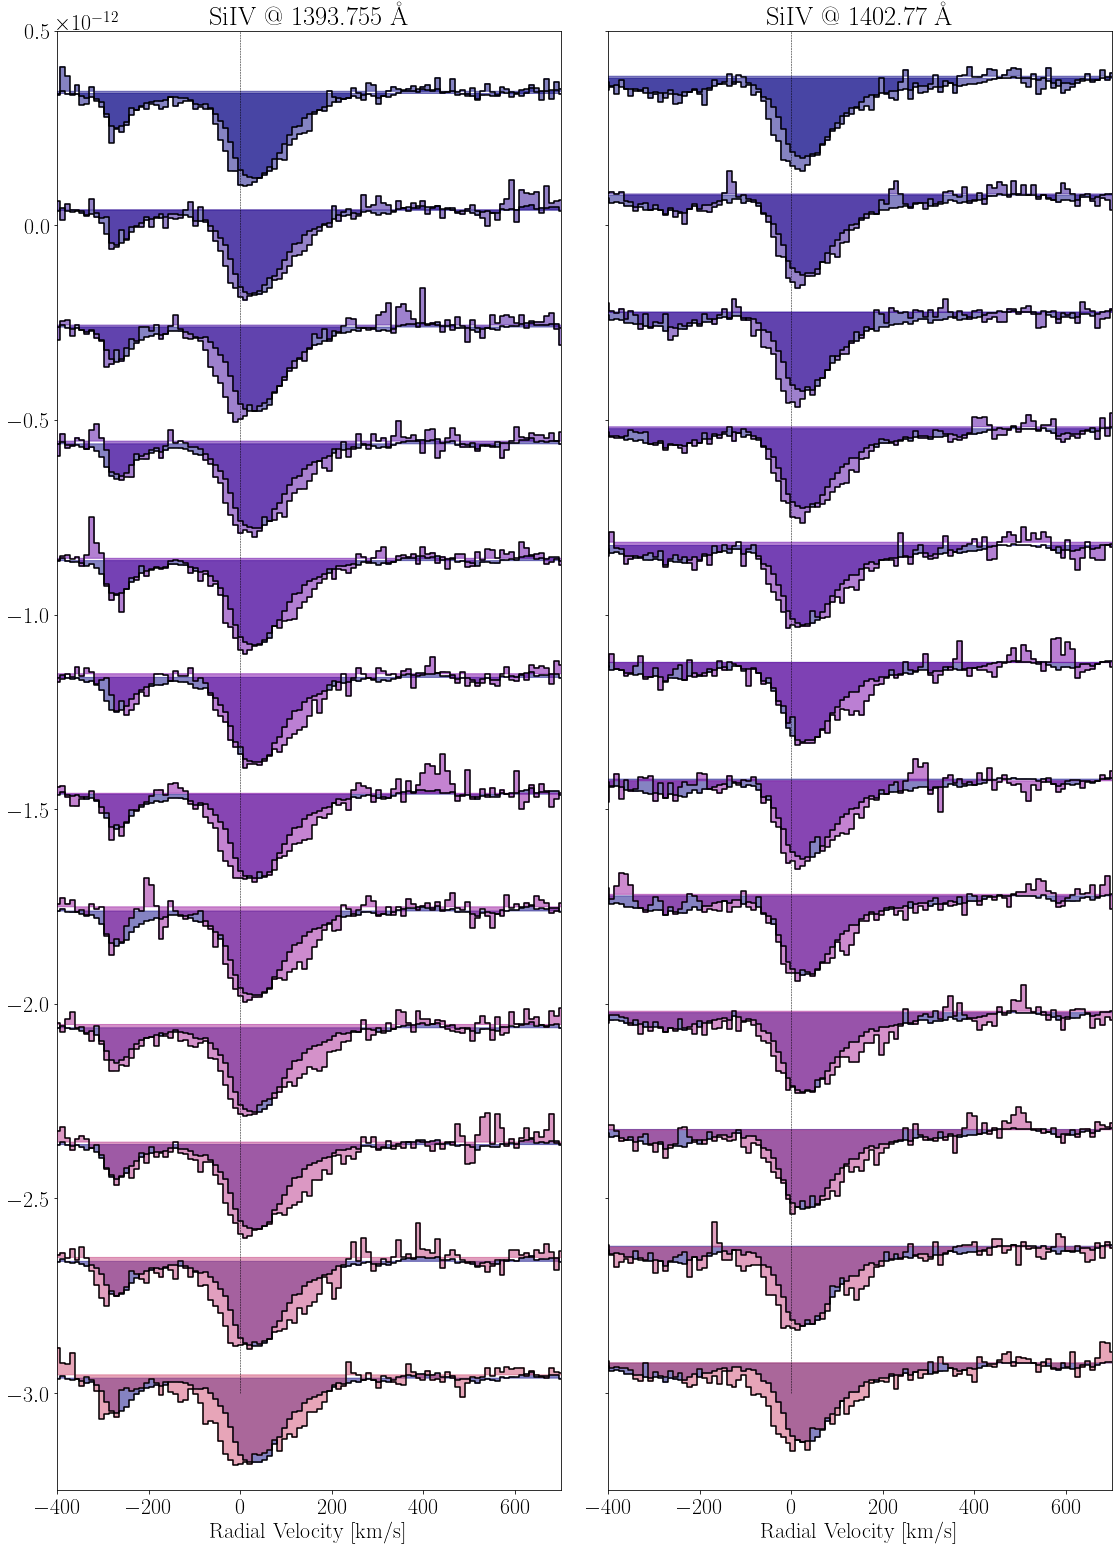

In [5]:
print('Looking at observations done on:')

# We loop over all the visits given in params.json
for nobs in range(len(DP)):
    
    # We extract the date so we can put it on the y-axis of the plot
    date = str(DP[nobs][0][3])[:10]
    
    fig = plt.figure(figsize=(16.0,22.0))

    print('\n',date)
    
    ax1 = plt.subplot(121)
    
    rv = c.Wave2RV(DP[nobs][0][0],Line1,20.5) # Convert to RV space
    x, y = c.BinXY(rv,DP[nobs][0][1],bin_size) # Bin the data

    s1, s2 = c.RegionSelect(x, n1, n2)

    # Plot the vertical line at v = 0 km/s
    plt.plot([0,0],[-3.0e-12,0.5e-12],'--k',lw=0.5)

    ticks = []
    times = []

    # In this plot we want to compare each observation to the first one:
    #x1, y1 = c.BinXY(rv,DP[nobs][0][1],bin_size)

    # In this plot we want to compare each observation to the exocomet free spectrum:
    x1, y1 = c.BinXY(rv,ECF,bin_size)

    for i in range(len(DP[nobs])):
        offset = i*3e-13
        x, y = c.BinXY(rv,DP[nobs][i][1],bin_size)

        ticks.append(np.median(y[s1:s2])-offset)
        times.append(str(DP[nobs][i][3])[11:])

        plt.step(x1,y1-offset,color="black",label=str(DP[nobs][i][3])[11:])
        plt.fill_between(x1,y1-offset,np.median(y1[s1:s2])*np.ones(len(x1))-offset,step='pre',color=cool[0],alpha=0.5)
        plt.step(x,y-offset,color="black",label=str(DP[nobs][i][3])[11:])
        plt.fill_between(x,y-offset,np.median(y[s1:s2])*np.ones(len(x))-offset,step='pre',color=cool[i],alpha=0.5)
    plt.xlabel(r'Radial Velocity [km/s]')
    plt.xlim(-400,700)
    plt.ylim(-3.25e-12,0.5e-12)
    #plt.gca().set_yticks(ticks) 
    #plt.gca().set_yticklabels(times)


    ax2 = plt.subplot(122)

    rv = c.Wave2RV(DP[nobs][0][0],Line2,20.5)
    x, y = c.BinXY(rv,DP[nobs][0][1],bin_size)

    s1, s2 = c.RegionSelect(x, n1, n2)

    plt.plot([0,0],[-3.0e-12,0.5e-12],'--k',lw=0.5)

    #x1, y1 = c.BinXY(rv,DP[nobs][0][1],bin_size)
    x1, y1 = c.BinXY(rv,ECF,bin_size)

    for i in range(len(DP[nobs])):
        offset = i*3e-13
        x, y = c.BinXY(rv,DP[nobs][i][1],bin_size)

        ticks.append(np.median(y[s1:s2])-offset)
        times.append(str(DP[nobs][i][3])[11:])

        plt.step(x1,y1-offset,color="black",label=str(DP[nobs][i][3])[11:])
        plt.fill_between(x1,y1-offset,np.median(y1[s1:s2])*np.ones(len(x1))-offset,step='pre',color=cool[0],alpha=0.5)
        plt.step(x,y-offset,color="black",label=str(DP[nobs][i][3])[11:])
        plt.fill_between(x,y-offset,np.median(y[s1:s2])*np.ones(len(x))-offset,step='pre',color=cool[i],alpha=0.5)

    plt.xlabel(r'Radial Velocity [km/s]')

    ax2.set(yticklabels=[]) 
    ax2.set(ylabel=None)     

    plt.xlabel(r'Radial Velocity [km/s]')
    plt.xlim(-400,700)
    plt.ylim(-3.25e-12,0.5e-12)
    ax1.title.set_text('SiIV @ '+str(Line1)+' \AA')
    ax2.title.set_text('SiIV @ '+str(Line2)+' \AA')
    fig.tight_layout()
    plt.savefig(home+'/plots/comparison/'+date+'.pdf', bbox_inches='tight', pad_inches=0.1,dpi=300)

For the following cell I had to run it a few times to get it running as excpected. Not sure yet why that is.

█▓▒▒░░░ Visit: 0 ░░░▒▒▓█
[160.64762848  12.58934503  35.56429955   9.98968724]
	 -22.33640329483648
[166.16884613  12.62749977  34.20621742   9.99999353]
	 -24.743799854428392
[155.4481627   11.79954411  30.0000044    9.98000001]
	 -34.02757796891824
[166.33177617  12.84742503  56.62144437  10.        ]
	 -24.244273883770415
[167.40940529  12.73006007  31.33954566   9.9999729 ]
	 -21.598967874204863
[165.34590313  12.87428682  41.40584844   9.98003979]
	 -34.34194539943199
[175.64702071  12.84093429  46.08553591   9.98009559]
	 -33.50898400033935
[175.16851083  12.93277749  39.41631546   9.9999976 ]
	 -17.498754246220017
[202.46153487  13.02603289  58.14305866   9.99999642]
	 -31.946266990740668
[180.54104051  13.03845958  57.31431664   9.98017775]
	 -23.60587498505895
[183.2523312   12.99846469  54.65844126   9.98000027]
	 -40.441948960622035
[174.64306596  12.81304033  36.99325983   9.99980107]
	 -45.559461625283696
[150.          12.87638123  85.          10.        ]
	 -45.55946162

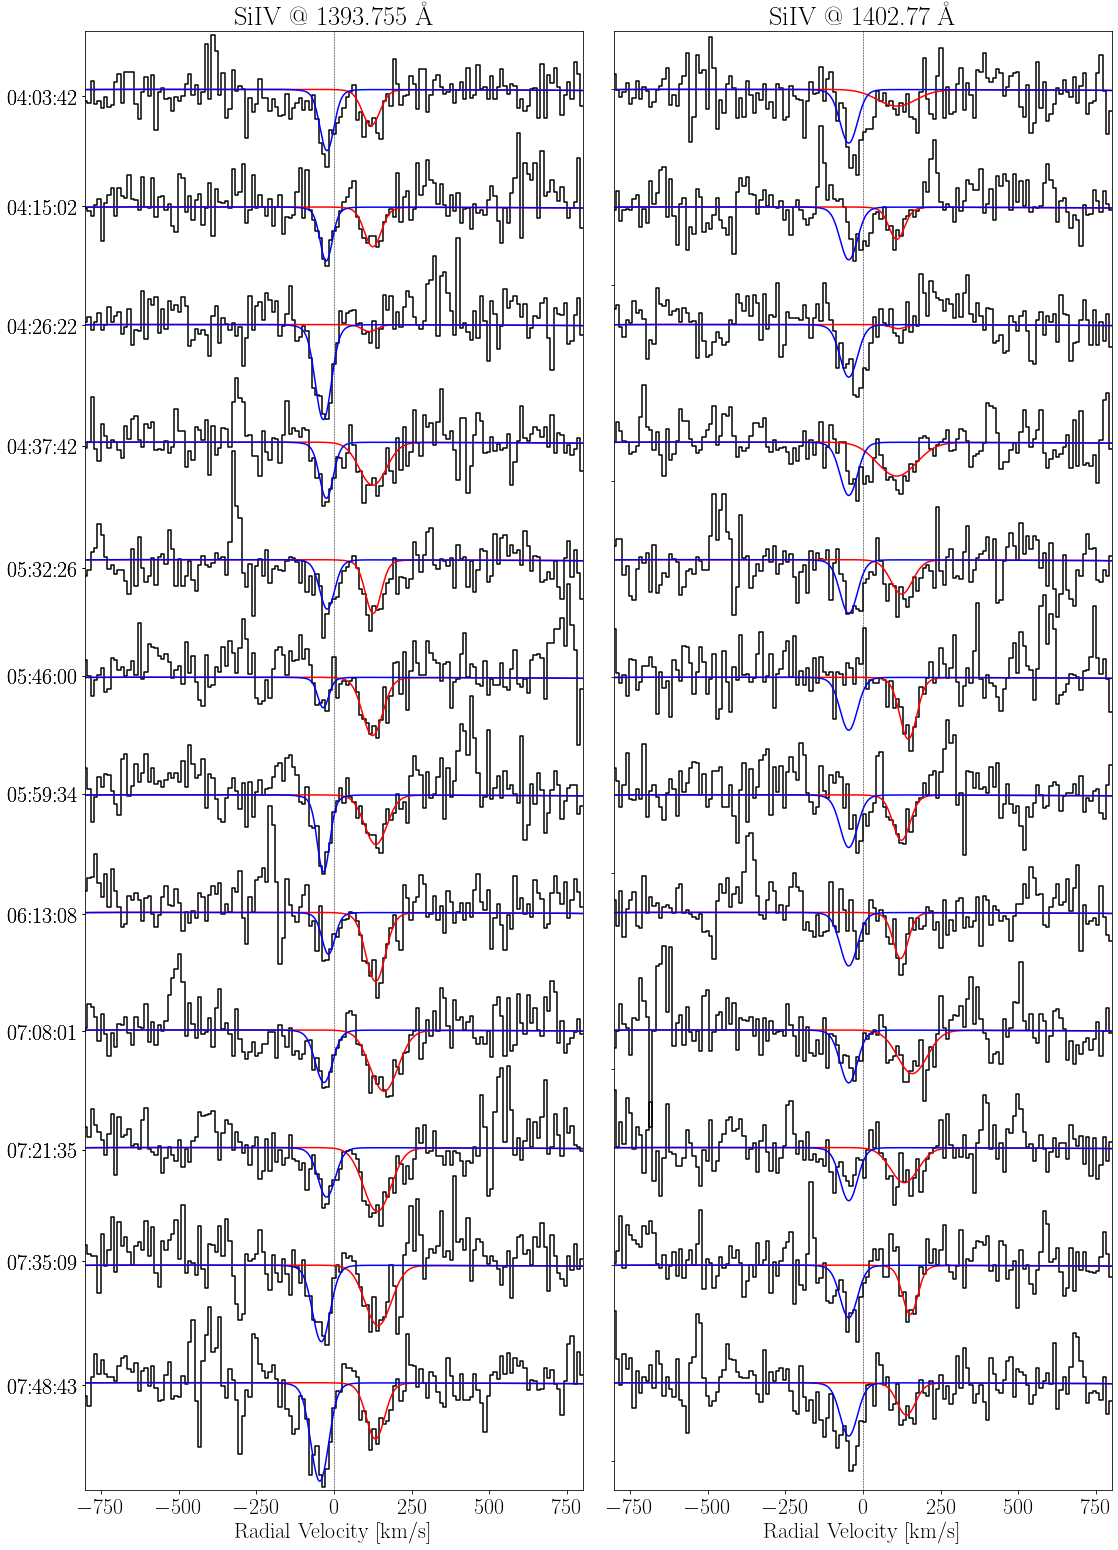

In [66]:
from scipy.optimize import curve_fit

def gauss(x,a,x0,sigma):
    return -a*np.exp(-(x-x0)**2/(2*(sigma)**2))


bin_size = 5

lines = [1393.7550, 1402.7700]

# These numbers must be symetric
g1 = -1000
g2 = 1000

# len(DP) --> number of visits with multiple observations
# 2 --> Number of lines being studied (2 because we are looking at a doublet)
# len(DP[nobs]) --> number of orbits within a visit

v_comp = np.zeros(shape=(len(DP),2, len(DP[nobs])))
N = np.zeros(shape=(len(DP),2, len(DP[nobs])))
v_turb = np.zeros(shape=(len(DP),2, len(DP[nobs])))
temp = np.zeros(shape=(len(DP),2, len(DP[nobs])))

v_comp_err = np.zeros(shape=(len(DP),2, len(DP[nobs])))
N_err = np.zeros(shape=(len(DP),2, len(DP[nobs])))
v_turb_err = np.zeros(shape=(len(DP),2, len(DP[nobs])))
temp_err = np.zeros(shape=(len(DP),2, len(DP[nobs])))


diffg = np.zeros(shape=(len(DP),2, len(DP[nobs])))

# Run a loop over the number of visits

for nobs in range(len(DP)):
    
    print("█▓▒▒░░░ Visit:",nobs,"░░░▒▒▓█")
    
    w = DP[nobs][0][0]
    
    fig = plt.figure(figsize=(16.0,22.0))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    ax1.plot([0,0],[-3.2e-12,0.5e-12],'--k',lw=0.5)
    ax2.plot([0,0],[-3.2e-12,0.5e-12],'--k',lw=0.5)

    date = str(DP[nobs][0][3])[:10]

    # The spectrum we are comparing to
    rv_bin, f_bin = c.BinXY(rv,DP[nobs][0][1],bin_size)
    s1, s2 = c.RegionSelect(x, n1, n2)
    e1, e2 = c.RegionSelect(rv, n1, n2)

    ticks = []
    times = []

    # We choose the exocomet free spectrum as a comparison
    rv_bin1, f_bin1 = c.BinXY(rv,ECF,bin_size)


    # Run a loop over the number of lines being explored.
    # In this case the 1393.7550 and 1402.7700 lines
    for j in range(2):

        rv = c.Wave2RV(w,lines[j],20.5)

        l = np.arange(lines[j]-5,lines[j]+5,0.01)
        rv_l = c.Wave2RV(l,lines[j],20.5)
        
        # Select the region which will be used for fitting the Gaussian
        gg1, gg2 = c.RegionSelect(rv, g1, g2)

        # Run a loop over each exposure
        for i in range(len(DP[nobs])):

            offset = i*1.2e-13#/ 2.5e-13
            
            f = DP[nobs][i][1]

            # Next spectrum
            rv_bin, f_bin = c.BinXY(rv,DP[nobs][i][1],bin_size)

            ticks.append(np.median(f_bin1[s1:s2]-f_bin[s1:s2])-offset)
            times.append(str(DP[nobs][i][3])[11:])

            # Calculate the difference between the spectra

            # Using the exocomet free spectrum
            diffg = (DP[nobs][i][1]-ECF)[gg1:gg2]

            diff_err = (np.sqrt(DP[nobs][i][2]**2+ECF_err**2))[gg1:gg2]
            w_c = w[gg1:gg2]
            rv_c = c.Wave2RV(w_c,lines[j],20.5)
            
            # Fit a Gaussian to the data
            try:                   
                if j == 0:
                    popt,pcov = curve_fit(m.absorptionSiIV_1,w_c,(diffg/np.median(f[e1:e2]))+1.0,\
                                          p0=[175,12.9,40,9.99],bounds=([150, 11, 30, 9.98], [230, 15, 85, 10]), maxfev = 800)
                    popt2,pcov2 = curve_fit(m.absorptionSiIV_1,w_c,(diffg/np.median(f[e1:e2]))+1.0,\
                                          p0=[20,13,20,9.5],bounds=([-20, 11, 15, 9], [40, 15, 35, 10]), maxfev = 800)
                    ax1.step(rv_bin,f_bin-f_bin1+np.median(f_bin1[s1:s2]-f_bin[s1:s2])*np.ones(len(x))-offset,'-k')
                    ax1.plot(rv_c,(m.absorptionSiIV_1(w_c,*popt)-1.0)*np.median(f[e1:e2])-offset,'-r')
                    ax1.plot(rv_c,(m.absorptionSiIV_1(w_c,*popt2)-1.0)*np.median(f[e1:e2])-offset,'-b')
                    
                    #ax1.fill_between(rv_bin,f_bin-f_bin1+np.median(f_bin1[s1:s2]-f_bin[s1:s2])*np.ones(len(x))-offset,np.median(f_bin1[s1:s2]-f_bin[s1:s2])*np.ones(len(x))-offset,step='pre',color=cool[i],alpha=0.5)
                    
                if j == 1:
                    popt,pcov = curve_fit(m.absorptionSiIV_2,w_c,(diffg/np.median(f[e1:e2]))+1.0,\
                                          p0=[175,12.9,40,9.99],bounds=([150, 11, 30, 9.98], [230, 15, 85, 10]), maxfev = 800)
                    #popt2,pcov2 = curve_fit(m.absorptionSiIV_1,w_c,(diffg/np.median(f[e1:e2]))+1.0,\
                    #                      p0=[20,13,20,9.5],bounds=([-20, 11, 15, 9], [40, 15, 35, 10]), maxfev = 800)
                    ax2.step(rv_bin,f_bin-f_bin1+np.median(f_bin1[s1:s2]-f_bin[s1:s2])*np.ones(len(x))-offset,'-k')
                    ax2.plot(rv_c,(m.absorptionSiIV_2(w_c,*popt)-1.0)*np.median(f[e1:e2])-offset,'-r')
                    ax2.plot(rv_c,(m.absorptionSiIV_2(w_c,*popt2)-1.0)*np.median(f[e1:e2])-offset,'-b')
                    #ax2.fill_between(rv_bin,f_bin-f_bin1+np.median(f_bin1[s1:s2]-f_bin[s1:s2])*np.ones(len(x))-offset,np.median(f_bin1[s1:s2]-f_bin[s1:s2])*np.ones(len(x))-offset,step='pre',color=cool[i],alpha=0.5)

                    
                    
                # CHECK WHY -41!
                
                
                print(popt)
                print('\t',popt2[0]-41)

                # Calculate the uncertainties on the parameters
                perr = np.sqrt(np.diag(pcov))

                # Store the fit parameters
                v_comp[nobs][j][i] = popt[0]-41
                N[nobs][j][i] = popt[1]
                v_turb[nobs][j][i] = popt[2]
                temp[nobs][j][i] = popt[3]

                # Store the uncertainties on the parameters
                v_comp_err[nobs][j][i] = perr[0]
                N_err[nobs][j][i] = perr[1]
                v_turb_err[nobs][j][i] = perr[2]
                temp_err[nobs][j][i] = perr[3] 
                    
            except RuntimeError:
                
                print("Not able to fit")
 
                # Calculate the uncertainties on the parameters
                '''
                perr = np.array([1e-12, 100, 20])

                # Store the fit parameters
                amplitude[nobs][j][i-1] = 0
                shift[nobs][j][i-1] = 0
                width[nobs][j][i-1] = 0

                # Store the uncertainties on the parameters
                amplitude_err[nobs][j][i-1] = 0
                shift_err[nobs][j][i-1] = 0
                width_err[nobs][j][i-1] = 0

                if j == 0:
                    ax1.fill_between(x,y-y1+np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(x))-offset,np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(x))-offset,step='pre',color=cool[i],alpha=0.5)
                if j == 1:
                    ax2.fill_between(x,y-y1+np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(x))-offset,np.median(y1[s1:s2]-y[s1:s2])*np.ones(len(x))-offset,step='pre',color=cool[i],alpha=0.5)               
                '''
        ax1.title.set_text('SiIV @ '+str(Line1)+' \AA')
        ax1.set_xlim(-800,800)
        ax1.set_ylim(-1.43e-12,6.0e-14)
        ax1.set_xlabel(r'Radial Velocity [km/s]')
        ax1.set_yticks(ticks) 
        ax1.set_yticklabels(times)

        ax2.title.set_text('SiIV @ '+str(Line2)+' \AA')
        ax2.set_xlim(-800,800)
        ax2.set_ylim(-1.43e-12,6.0e-14)
        ax2.set_xlabel(r'Radial Velocity [km/s]')
        ax2.set(yticklabels=[]) 
        ax2.set(ylabel=None)  


        fig.tight_layout()
        plt.savefig(home+'/plots/fits/'+date+'_exocomets.pdf', bbox_inches='tight', pad_inches=0.1,dpi=300)


Date: 2018-03-17

	R =  9.0 ± 4.3 R*

	dvdt = 1.8 ± 0.9 m/s^2

	 1393.755
v_comp:	 p_value = 0.073
log(N):	 p_value = 0.133
v_turb:	 p_value = 0.663

	R =  7.1 ± 2.7 R*

	dvdt = 2.9 ± 1.1 m/s^2

	 1402.77
v_comp:	 p_value = 0.034 
log(N):	 p_value = 0.284
v_turb:	 p_value = 0.32



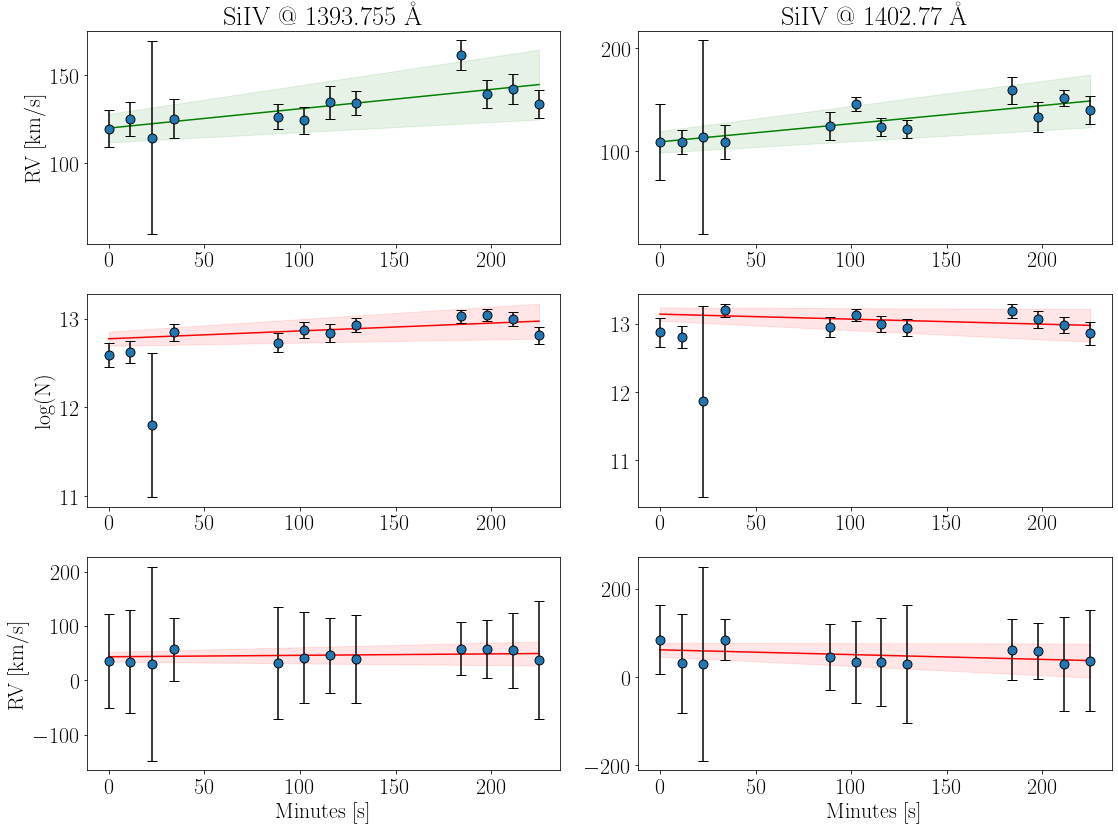

In [67]:
from datetime import timedelta
from scipy.stats import linregress
import datetime
from colorama import Fore, Back, Style

#minutes = np.zeros(shape=(len(DP),len(DP[nobs])))


plotting_params = {'backend': 'wxAgg',
                   'font.family': 'serif',
                   'font.size': 22,
                   'lines.markersize' : 2,
                   'axes.labelsize': 22,
                   'legend.fontsize': 22,
                   'xtick.labelsize': 22,
                   'ytick.labelsize': 22,
                   'text.usetex': True}

plt.rcParams.update(plotting_params)

for nobs in range(len(DP)):
    
    if nobs != 3:

        minutes = []
        date = str(DP[nobs][0][3])[:10]
        print("Date:",date)
        print(32*"=")

        #3 rows and 2 columns
        fig, axes = plt.subplots(3, 2, figsize=(16,12))  

        for i in range(len(DP[nobs])):
            time_sec = (DP[nobs][i][3] - datetime.datetime(1970, 1, 1)).total_seconds()
            #minutes[nobs][i] = time_sec/60 # Convert to minutes
            minutes.append(time_sec/60) # Convert to minutes

        minutes = np.array(minutes)
        #minutes[nobs] = (minutes[nobs]-minutes[nobs][0])
        minutes = minutes-minutes[0]



        for j in range(2):
            res1 = linregress(minutes[3:], v_comp[nobs][j][3:])
            if res1.pvalue < 0.10:
                colour = "green"
                print("\n\tR = ",round(c.RadCalc(res1[0]),1),"±",round(c.RadCalc(res1[0])*(res1.stderr/res1[0]),1),"R*")
                print("\n\tdvdt =",round(res1[0]*(1000/60.),1),"±",round(res1.stderr*(1000/60.),1),"m/s^2")
            else:
                colour = "red"
            axes[0][j].fill_between(minutes,(res1.slope+res1.stderr)*minutes+res1.intercept+res1.intercept_stderr,(res1.slope-res1.stderr)*minutes+res1.intercept-res1.intercept_stderr,color=colour,alpha=0.1)
            axes[0][j].plot(minutes,res1.slope*minutes+res1.intercept,color=colour)
            axes[0][j].errorbar(minutes,v_comp[nobs][j],yerr=v_comp_err[nobs][j],capsize=5,ls="None",color="black")
            axes[0][j].scatter(minutes,v_comp[nobs][j],s=80,zorder=2,color="black")
            axes[0][j].scatter(minutes,v_comp[nobs][j],s=50,zorder=2,label="Absorption depth")

            res2 = linregress(minutes[3:], N[nobs][j][3:])
            if res2.pvalue < 0.10:
                colour = "green"
            else:
                colour = "red"
            axes[1][j].fill_between(minutes,(res2.slope+res2.stderr)*minutes+res2.intercept+res2.intercept_stderr,(res2.slope-res2.stderr)*minutes+res2.intercept-res2.intercept_stderr,color=colour,alpha=0.1)
            axes[1][j].plot(minutes,res2.slope*minutes+res2.intercept,color=colour)
            axes[1][j].errorbar(minutes,N[nobs][j],yerr=N_err[nobs][j],capsize=5,ls="None",color="black")
            axes[1][j].scatter(minutes,N[nobs][j],s=80,zorder=2,color="black")
            axes[1][j].scatter(minutes,N[nobs][j],s=50,zorder=2,label="Absorption depth")    

            res3 = linregress(minutes[3:], v_turb[nobs][j][3:])
            if res3.pvalue < 0.10:
                colour = "green"
            else:
                colour = "red"
            axes[2][j].fill_between(minutes,(res3.slope+res3.stderr)*minutes+res3.intercept+res3.intercept_stderr,(res3.slope-res3.stderr)*minutes+res3.intercept-res3.intercept_stderr,color=colour,alpha=0.1)
            axes[2][j].plot(minutes,res3.slope*minutes+res3.intercept,color=colour)
            axes[2][j].errorbar(minutes,v_turb[nobs][j],yerr=v_turb_err[nobs][j],capsize=5,ls="None",color="black")
            axes[2][j].scatter(minutes,v_turb[nobs][j],s=80,zorder=2,color="black")
            axes[2][j].scatter(minutes,v_turb[nobs][j],s=50,zorder=2,label="Absorption depth")    

            print("\n\t",lines[j])
            if res1.pvalue < 0.05:
                print(Back.GREEN + 'v_comp:\t p_value =',round(res1.pvalue,3),Style.RESET_ALL)
            else:
                print('v_comp:\t p_value =',round(res1.pvalue,3))
            if res2.pvalue < 0.05:
                print(Back.GREEN + 'log(N):\t p_value =',round(res2.pvalue,3),Style.RESET_ALL)
            else:
                print('log(N):\t p_value =',round(res2.pvalue,3))
            if res3.pvalue < 0.05:
                print(Back.GREEN + 'v_turb:\t p_value =',round(res3.pvalue,3),Style.RESET_ALL)
            else:
                print('v_turb:\t p_value =',round(res3.pvalue,3))

            #with open(home+'/data/variations_'+date+'.txt', 'w') as output:
            #    output.write('Amplitude:\t p_value = '+str(round(res1.pvalue,3))+'\n')

        axes[0][0].set_ylabel(r'RV [km/s]')
        axes[0][0].title.set_text('SiIV @ '+str(Line1)+' \AA')
        axes[0][1].title.set_text('SiIV @ '+str(Line2)+' \AA')
        axes[1][0].set_ylabel(r'log(N)')
        axes[2][0].set_ylabel(r'RV [km/s]')
        axes[2][0].set_xlabel(r'Minutes [s]')
        axes[2][1].set_xlabel(r'Minutes [s]')
        fig.tight_layout()
        plt.savefig(home+'/plots/trends/'+date+'_fit_parameters.pdf', bbox_inches='tight', pad_inches=0.1,dpi=300)
        print(32*"=","\n")

/home/pas/science/exocomets/src/calculations.py:582: RuntimeWarning: invalid value encountered in true_divide
  LSF_kernel      = LSF_kernel/np.sum(LSF_kernel)


(-400.0, 400.0)

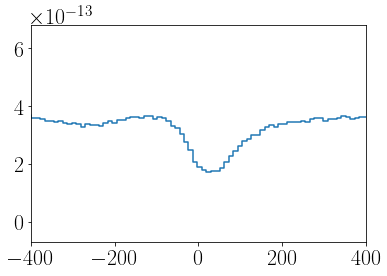

In [8]:
#l = np.arange(1390,1400,0.01)
rv_l = c.Wave2RV(l,1393.755,0)
model = m.absorptionSiIV_1(l,30.5, 13.6, 50.5, 10)

plt.step(x,y1)
plt.plot(rv_l,model*np.median(y1[s1:s2]))

plt.xlim(-400,400)